In [1]:
!pip install git+https://github.com/Qip21n0/Lassolver.git

  Cloning https://github.com/Qip21n0/Lassolver.git to /tmp/pip-req-build-j58k4d6h
  Running command git clone -q https://github.com/Qip21n0/Lassolver.git /tmp/pip-req-build-j58k4d6h
  Created wheel for lassolver: filename=lassolver-0.2.6-py3-none-any.whl size=14036 sha256=84fad276ee6c321c66f1467d306f7e17511ef19f7a8a815d42fdb7f019d7daa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-iia23h0h/wheels/5c/0b/77/92d6595822ec0c5e1c27d209f3bcae9296385c30ce4a38cf06
Successfully built lassolver


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
from lassolver.utils.func import *
from lassolver.utils.signal import *
from lassolver.utils.utils import *

from lassolver.matrices.iid_gauss import iidGaussian
from lassolver.matrices.uni_invar import UniInvar

from lassolver.solver.amp import AMP
from lassolver.solver.oamp import OAMP

from lassolver.dsolver.d_amp import D_AMP
from lassolver.dsolver.d_oamp import D_OAMP
from lassolver.dsolver.d_base import dbase, D_Base

In [5]:
def gcoamp(w, tau_p, log=False, ord=None):
    shita = 0.7
    tau = np.sum(tau_p)
    communication_cost = 0
    P, N, _ = w.shape
    R = np.zeros((P, N, 1))
    z = [0] * N
    
    #STEP1
    for p in range(1, P):
        R[p] = np.square(w[p]) > tau_p[p] * shita
        candidate = np.where(R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n, w[p, n])
    
    #STEP2
    S = [np.where(R[:, n])[0] for n in range(N)]
    m = np.sum(R, axis=0)
    U = np.empty((N, 1))
    for n in range(N):
        upper = np.sum([tau_p[p] for p in range(1, P) if p not in S[p]])
        z[n] = w[0, n] + np.sum([w[p, n] for p in S[n]])
        U[n] = z[n]**2 + upper * shita
    F = (U > tau) * (m < (P-1))
    candidate = np.where(F)[0]
    for n in candidate:
        communication_cost += 1
        broadcast_others(n)
    
    #STEP3
    F_R = F * np.logical_not(R)
    for p in range(1, P):
        #print("p: {}".format(p))
        candidate = np.where(F_R[p])[0]
        for n in candidate:
            communication_cost += 1
            send_to1(n ,w[p, n])
    if log: 
        print("Rp: {} \t F: {} \t F\\Rp: {}".format(np.sum(R), np.sum(F), np.sum(F_R)-np.sum(F)))
        print("Total Communication Cost: {}".format(communication_cost))
        print("="*50)
    
    #STEP4
    u = np.zeros((N, 1))
    b = np.zeros((N, 1))
    V = np.where(U > tau)[0].tolist()
    for n in V:
        b[n] = np.sum(w[:, n])
        u[n] = soft_threshold(b[n], tau**0.5)
    
    #STEP5
    Vc = [n for n in range(N) if n not in V]
    z_exe = {'0', '1'}
    rand_exe = {'0', '2'}
    for n in Vc:
        b[n] = z[n] if ord in z_exe else 0
        b[n] += np.sum([rand(shita * tau_p[p]) for p in range(1, P) if p not in S[n]]) if ord in rand_exe else 0
        
    s = u - np.mean(u != 0)*b
    return s.real, communication_cost

In [6]:
class dtest(dbase):
    def __init__(self, A_p, x, snr, M):
        super().__init__(A_p, x, snr, M)

    def receive_s(self, s):
        self.s = s.copy()

    def receive_W_p(self, W_p):
        self.W_p = W_p.copy()

    def receive_trX2(self, trW_p2, trB2):
        self.trW_p2 = trW_p2
        self.trB2 = trB2

    def receive_trA2(self, trA2):
        self.trA2 = trA2

    def local_compute(self):
        self.r_p = self._update_r_p()
        w_p = self._update_w_p()
        v_p = self._update_v_p()
        tau_p = self._update_tau_p(v_p)
        return w_p, v_p, tau_p

    def _update_r_p(self):
        return self.y - self.A_p @ self.s

    def _update_w_p(self):
        return self.s / self.P + self.W_p @ self.r_p

    def _update_v_p(self):
        v_p = (np.linalg.norm(self.r_p)**2 - self.M_p * self.sigma_p) / self.trA2
        return v_p

    def _update_tau_p(self, v_p):
        return 1 / self.N * (self.trB2 * v_p + self.trW_p2 * self.sigma_p)

In [7]:
class D_Test(D_Base):
    def __init__(self, A, x, noise, P):
        super().__init__(A, x, noise, P)
        self.A = A.copy()
        self.AT = self.A.T
        self.AAT = self.A @ self.AT
        self.I = np.eye(self.M)
        self.c = (self.N - self.M) / self.M
        self.oamps = [dtest(self.A_p[p], x, self.noise[p], self.M) for p in range(self.P)]
        self.sigma = self.__set_sigma()
        self.trA2 = self.__set_trA2()

    def __set_sigma(self):
        sigma = 0
        for p in range(self.P):
            sigma += self.oamps[p].sigma_p
        return sigma / self.P
    
    def __set_trA2(self):
        trA2 = 0
        for p in range(self.P):
            trA2 += self.oamps[p].trA2_p
        return trA2

    def estimate(self, T=20, C=1.85, ord='LMMSE', log=False, gctype=None):
        self.gctype = gctype
        w = np.zeros((self.P, self.N, 1))

        v = (np.sum([np.linalg.norm(self.oamps[p].y)**2 for p in range(self.P)]) - self.M_p * self.sigma) / self.trA2
        self.W = self.__set_W(v, ord)
        self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
        
        I = np.eye(self.N)
        B = I - self.W @ self.A
        self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
        self.trB2 = np.trace(B @ B.T)

        for p in range(self.P):
            self.oamps[p].receive_W_p(self.W_p[p].T)
            self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
            self.oamps[p].receive_trA2(self.trA2)
        
        for t in range(T):
            for p in range(self.P):
                w[p], self.v_p[p], self.tau_p[p] = self.oamps[p].local_compute()
            #w[0] += self.s
            v = self._update_v()
            tau = self._update_tau()
            if log: print("{}/{}: tau = {}, v = {}".format(t+1, T, tau, v))
            self._update_s(C, w, log)

            for p in range(self.P):
                self.oamps[p].receive_s(self.s)
            self._add_mse()
            if t == T-1: break
            if ord == 'LMMSE':
                self.W = self.__set_W(v, ord='LMMSE')
                self.W_p = self.W.T.reshape(self.P, self.M_p, self.N)
                B = I - self.W @ self.A
                self.trW2 = [np.trace(W_p.T @ W_p) for W_p in self.W_p]
                self.trB2 = np.trace(B @ B.T)
                for p in range(self.P):
                    self.oamps[p].receive_W_p(self.W_p[p].T)
                    self.oamps[p].receive_trX2(self.trW2[p], self.trB2)
        
        #self._output_s(w, log)
        #self._add_mse()

    def __set_W(self, v, ord):
        if ord == 'MF':
            W_ = self.AT
        elif ord == 'PINV':
            W_ = np.linalg.pinv(self.A)
        elif ord == 'LMMSE':
            W_ = v * self.AT @ np.linalg.inv(v * self.AAT + self.sigma * self.I)
        else :
            raise NameError("not correct")
        return self.N / np.trace(W_ @ self.A) * W_

    def _update_v(self):
        #r2 = np.sum(self.r2)
        #v = (r2 - self.M * self.sigma) / self.trA2
        v = np.sum(self.v_p)
        v = v if v > 0 else 1e-4
        self.v.append(v)
        return v

    def _update_tau(self):
        #return 1/self.N * (self.trB2 * v + self.trW2 * self.sigma)
        return np.sum(self.tau_p)

    def _update_s(self, C, w, log):
        s, communication_cost = gcoamp(w, self.tau_p, log, self.gctype)
        self.s = C * s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

    def _output_s(self, w, log):
        s, communication_cost = GCAMP(w, self.tau_p, log)
        self.s = s
        self.communication_cost = np.append(self.communication_cost, communication_cost)

In [80]:
N = 4000
alpha = 0.5
M = int(alpha*N)
rho = 0.2

In [81]:
kappa = 5
P = 10
T = 40

In [82]:
x = bernouli_gaussian(N, rho)
SNR = 50
mode = 'LMMSE'

In [83]:
iidG = iidGaussian(M, N, 0, 1/M)
SNRdB = 10**(0.1*SNR)
sigma = np.linalg.norm(iidG.A @ x)**2 / SNRdB
noise = np.random.normal(0, sigma**0.5, (M, 1))

In [84]:
oamp = OAMP(iidG.A, x, noise)
test = [D_Test(iidG.A, x, noise, P) for _ in range(4)]

In [85]:
%%prun
oamp.estimate(T=T, ord=mode)

final mse: 0.08184604705162803


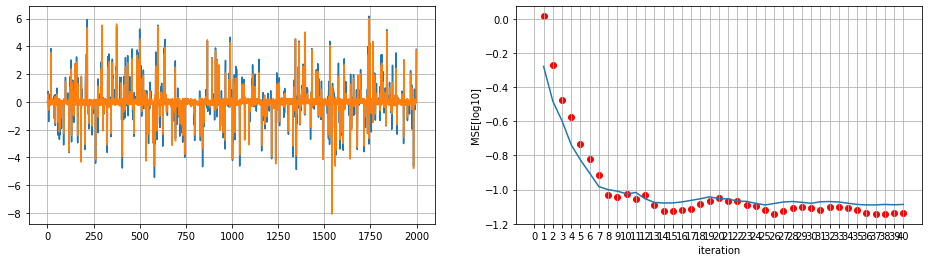

In [86]:
oamp.result()

## $z[n]$と乱数を含む手法(現提案手法)

In [87]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[0].estimate(T=T, ord=mode, log=True, gctype='0')

N(P-1): 18000

1/40: tau = 1.072019375021982, v = 1.0365557238584258
Rp: 11714.0 	 F: 887 	 F\Rp: 2750
Total Communication Cost: 15351
2/40: tau = 0.4944373982843765, v = 0.45928921164668224
Rp: 11824.0 	 F: 1050 	 F\Rp: 3222
Total Communication Cost: 16096
3/40: tau = 0.35648622857774975, v = 0.3220352683347644
Rp: 11735.0 	 F: 950 	 F\Rp: 2942
Total Communication Cost: 15627
4/40: tau = 0.2482184527092885, v = 0.21439433864927432
Rp: 11723.0 	 F: 988 	 F\Rp: 3006
Total Communication Cost: 15717
5/40: tau = 0.1889740653318442, v = 0.15589744157486768
Rp: 11509.0 	 F: 1002 	 F\Rp: 3187
Total Communication Cost: 15698
6/40: tau = 0.15535624482639587, v = 0.1229449983978108
Rp: 11544.0 	 F: 973 	 F\Rp: 3075
Total Communication Cost: 15592
7/40: tau = 0.13692593751003548, v = 0.10501191399476688
Rp: 11318.0 	 F: 847 	 F\Rp: 2768
Total Communication Cost: 14933
8/40: tau = 0.10778139509364168, v = 0.07670403869888276
Rp: 11311.0 	 F: 891 	 F\Rp: 2908
Total Communication Cost: 15110
9/40: t

final mse: 0.05659347844207734


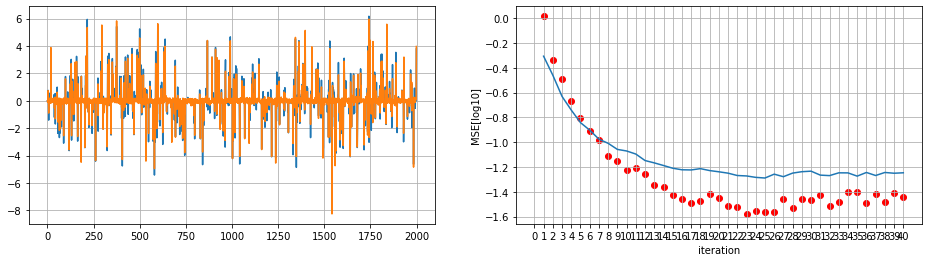

In [88]:
test[0].result()

## $z[n]$は含むが, 乱数は含まない手法

In [89]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[1].estimate(T=T, ord=mode, log=True, gctype='1')

N(P-1): 18000

1/40: tau = 1.072019375021982, v = 1.0365557238584258
Rp: 11714.0 	 F: 887 	 F\Rp: 2750
Total Communication Cost: 15351
2/40: tau = 0.47732757721284036, v = 0.4421887346616949
Rp: 11895.0 	 F: 1006 	 F\Rp: 3007
Total Communication Cost: 15908
3/40: tau = 0.3410278049271823, v = 0.30664030608998005
Rp: 11720.0 	 F: 894 	 F\Rp: 2809
Total Communication Cost: 15423
4/40: tau = 0.2180984642430913, v = 0.184467112052442
Rp: 11708.0 	 F: 945 	 F\Rp: 2925
Total Communication Cost: 15578
5/40: tau = 0.1712191874470686, v = 0.13845789618745907
Rp: 11421.0 	 F: 963 	 F\Rp: 3067
Total Communication Cost: 15451
6/40: tau = 0.138772122426686, v = 0.1067345245392621
Rp: 11452.0 	 F: 1001 	 F\Rp: 3239
Total Communication Cost: 15692
7/40: tau = 0.13183301025897257, v = 0.10010040416587325
Rp: 11309.0 	 F: 883 	 F\Rp: 2908
Total Communication Cost: 15100
8/40: tau = 0.09710263266042506, v = 0.06638380548513606
Rp: 11151.0 	 F: 901 	 F\Rp: 3074
Total Communication Cost: 15126
9/40: tau =

final mse: 0.04142455044868854


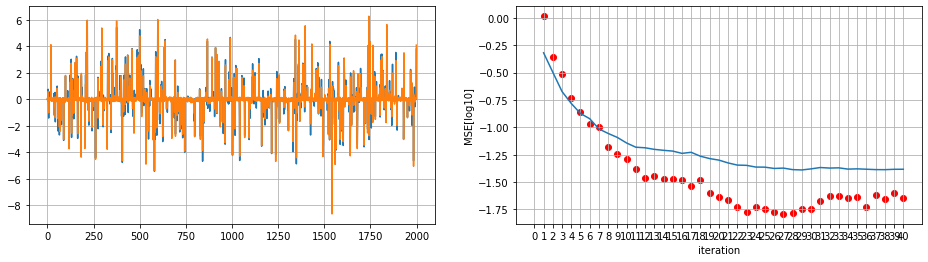

In [90]:
test[1].result()

## $z[n]$は含まないが, 乱数は含む手法

In [91]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[2].estimate(T=T, ord=mode, log=True, gctype='2')

N(P-1): 18000

1/40: tau = 1.072019375021982, v = 1.0365557238584258
Rp: 11714.0 	 F: 887 	 F\Rp: 2750
Total Communication Cost: 15351
2/40: tau = 0.37144465325968223, v = 0.33636363593074803
Rp: 11864.0 	 F: 1031 	 F\Rp: 3114
Total Communication Cost: 16009
3/40: tau = 0.3208970720255432, v = 0.2867219209181434
Rp: 11646.0 	 F: 969 	 F\Rp: 3096
Total Communication Cost: 15711
4/40: tau = 0.1844739642359705, v = 0.15110179744392702
Rp: 11641.0 	 F: 992 	 F\Rp: 3070
Total Communication Cost: 15703
5/40: tau = 0.16060960314670253, v = 0.12813768087721933
Rp: 11349.0 	 F: 953 	 F\Rp: 3084
Total Communication Cost: 15386
6/40: tau = 0.11016053244190417, v = 0.07876540777455787
Rp: 11283.0 	 F: 921 	 F\Rp: 3033
Total Communication Cost: 15237
7/40: tau = 0.1048354721685815, v = 0.07405688663763811
Rp: 11017.0 	 F: 918 	 F\Rp: 3145
Total Communication Cost: 15080
8/40: tau = 0.0917881305184664, v = 0.06157957100953626
Rp: 11115.0 	 F: 1014 	 F\Rp: 3531
Total Communication Cost: 15660
9/40: t

final mse: 0.04770166524434739


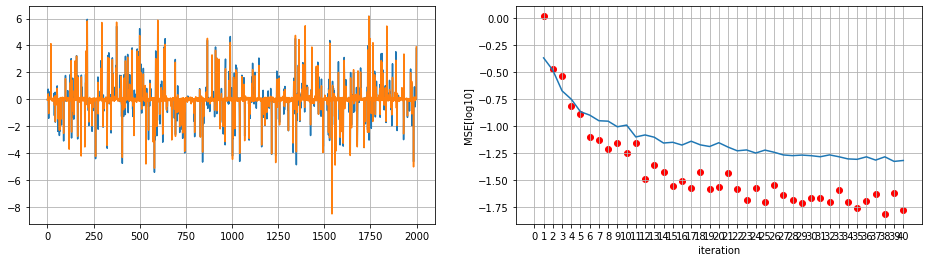

In [92]:
test[2].result()

## $z[n]$も乱数も含まない手法

In [93]:
%%prun
print("N(P-1): {}".format(N*(P-1)))
print()
test[3].estimate(T=T, ord=mode, log=True, gctype='3')

N(P-1): 18000

1/40: tau = 1.072019375021982, v = 1.0365557238584258
Rp: 11714.0 	 F: 887 	 F\Rp: 2750
Total Communication Cost: 15351
2/40: tau = 0.35323647380841194, v = 0.3181654004060669
Rp: 11847.0 	 F: 1107 	 F\Rp: 3386
Total Communication Cost: 16340
3/40: tau = 0.3275035469446365, v = 0.2933147548372805
Rp: 11618.0 	 F: 940 	 F\Rp: 2999
Total Communication Cost: 15557
4/40: tau = 0.1705161473018766, v = 0.13718986732438204
Rp: 11650.0 	 F: 965 	 F\Rp: 2937
Total Communication Cost: 15552
5/40: tau = 0.1376599960091935, v = 0.1056508394365599
Rp: 11273.0 	 F: 968 	 F\Rp: 3176
Total Communication Cost: 15417
6/40: tau = 0.11272552819205425, v = 0.08150862531114733
Rp: 11165.0 	 F: 965 	 F\Rp: 3226
Total Communication Cost: 15356
7/40: tau = 0.10504497687734325, v = 0.07424750331581716
Rp: 11115.0 	 F: 927 	 F\Rp: 3136
Total Communication Cost: 15178
8/40: tau = 0.08317132387352935, v = 0.0533310111426579
Rp: 10986.0 	 F: 902 	 F\Rp: 3111
Total Communication Cost: 14999
9/40: tau 

final mse: 0.07408460934700895


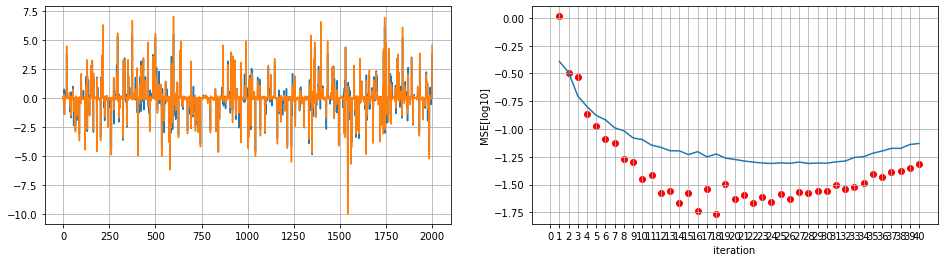

In [94]:
test[3].result()

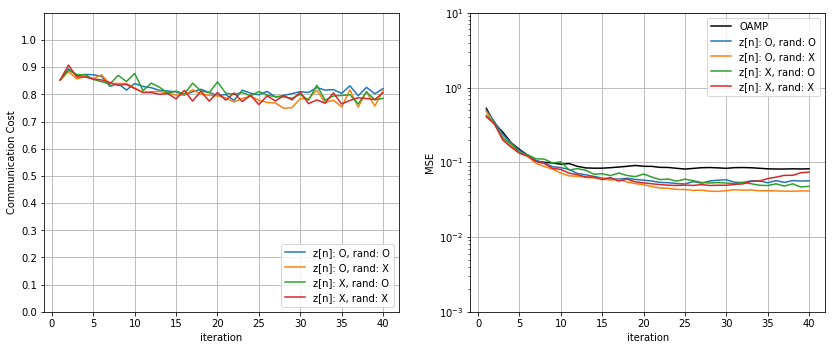

In [95]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt_CC(test[0].communication_cost, 'z[n]: O, rand: O', T, N, P)
plt_CC(test[1].communication_cost, 'z[n]: O, rand: X', T, N, P)
plt_CC(test[2].communication_cost, 'z[n]: X, rand: O', T, N, P)
plt_CC(test[3].communication_cost, 'z[n]: X, rand: X', T, N, P)
plt.grid()

plt.subplot(122)
plt_MSE(oamp.mse, 'OAMP', T, 'black')
plt_MSE(test[0].mse, 'z[n]: O, rand: O', T)
plt_MSE(test[1].mse, 'z[n]: O, rand: X', T)
plt_MSE(test[2].mse, 'z[n]: X, rand: O', T)
plt_MSE(test[3].mse, 'z[n]: X, rand: X', T)
plt.grid()

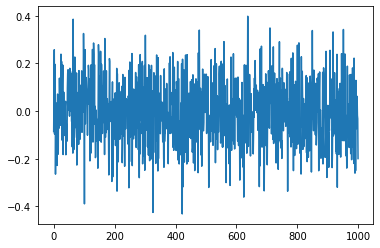

In [96]:
oamp_noise = oamp.n.copy().flatten()
plt.plot(oamp_noise)

In [97]:
test_noise = []
for i in range(4):
  n = np.empty(0)
  for p in range(P):
    n = np.append(n, test[i].oamps[p].y - test[i].oamps[p].A_p @ x)
  test_noise.append(n.flatten())

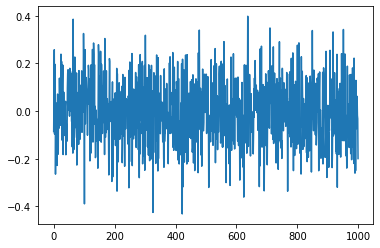

In [98]:
plt.plot(test_noise[0])

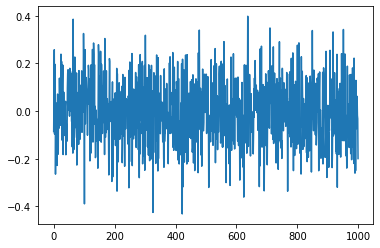

In [99]:
plt.plot(test_noise[1])

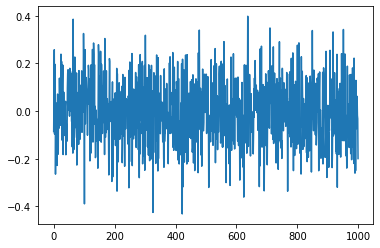

In [100]:
plt.plot(test_noise[2])

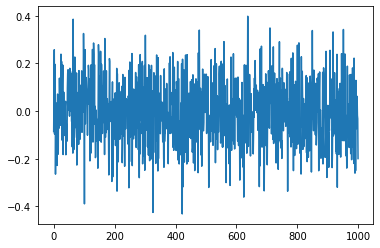

In [101]:
plt.plot(test_noise[3])

In [102]:
for i in range(4):
  norm = np.linalg.norm(oamp_noise - test_noise[i])
  print(norm)

2.2456769568201123e-15
2.2456769568201123e-15
2.2456769568201123e-15
2.2456769568201123e-15


In [103]:
N = 4000  # 列数
alpha = 0.5  # 圧縮率
M = int(alpha*N)  # 行数
rho = 0.2  # 非零成分の割合

In [104]:
SNR = 60  # 信号対雑音比
SNRdB = 10**(0.1*SNR)
kappa = 5  # 条件数
P = 2  # ノード数
T = 40  # 反復回数
sim = 10  # 実験数

In [105]:
xs = [bernouli_gaussian(N, rho) for _ in range(sim)]
l = 4
color = ['tab:blue', 'tab:orange', 'tab:red', 'tab:green']

In [106]:
MSE_iidG_oamp = np.empty((sim, T+1))

MSE_iidG_test = np.empty((sim, 4, T+1))
CommCost_iidG_test = np.empty((sim, 4, T))

In [107]:
for i in tqdm(range(sim)):
    iidG = iidGaussian(M, N, m=0, v=1/M)
    Ax = iidG.A @ xs[i]
    sigma = np.linalg.norm(Ax)**2 / SNRdB
    noise = np.random.normal(0, sigma**0.5, (M, 1))

    oamp = D_OAMP(iidG.A, xs[i], noise, 1)
    test = [D_Test(iidG.A, xs[i], noise, P) for _ in range(4)]

    oamp.estimate(T=T)
    MSE_iidG_oamp[i] = oamp.mse

    for j in range(4):
        test[j].estimate(T, gctype=str(j))
        MSE_iidG_test[i, j] = test[j].mse
        CommCost_iidG_test[i, j] = test[j].communication_cost

 40%|████      | 4/10 [2:10:28<3:15:42, 1957.12s/it]


KeyboardInterrupt: ignored

In [108]:
MSE_iidG_oamp_mean = np.mean(MSE_iidG_oamp, axis=0)

MSE_iidG_test_mean = np.empty((4, T+1))
CommCost_iidG_test_mean = np.empty((4, T))

for i in range(4):
    MSE_iidG_test_mean[i] = np.mean(MSE_iidG_test[:, i], axis=0)
    CommCost_iidG_test_mean[i] = np.mean(CommCost_iidG_test[:, i], axis=0)

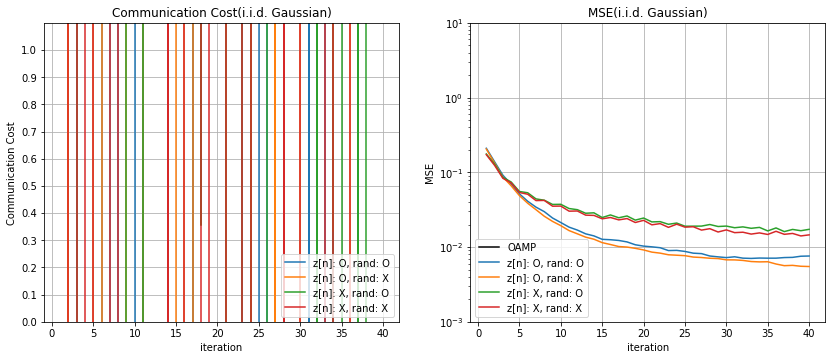

In [109]:
plt.figure(figsize=(14, 5.5))

plt.subplot(121)
plt.title('Communication Cost(i.i.d. Gaussian)')
plt_CC(CommCost_iidG_test_mean[0], 'z[n]: O, rand: O', T, N, P)
plt_CC(CommCost_iidG_test_mean[1], 'z[n]: O, rand: X', T, N, P)
plt_CC(CommCost_iidG_test_mean[2], 'z[n]: X, rand: O', T, N, P)
plt_CC(CommCost_iidG_test_mean[3], 'z[n]: X, rand: X', T, N, P)
plt.grid()

plt.subplot(122)
plt.title('MSE(i.i.d. Gaussian)')
plt_MSE(MSE_iidG_oamp_mean, 'OAMP', T, 'black')
plt_MSE(MSE_iidG_test_mean[0], 'z[n]: O, rand: O', T)
plt_MSE(MSE_iidG_test_mean[1], 'z[n]: O, rand: X', T)
plt_MSE(MSE_iidG_test_mean[2], 'z[n]: X, rand: O', T)
plt_MSE(MSE_iidG_test_mean[3], 'z[n]: X, rand: X', T)
plt.legend(loc="lower left")
plt.grid()